In [87]:
import sys
print(sys.version)

3.7.0 (default, Jun 28 2018, 08:04:48) [MSC v.1912 64 bit (AMD64)]


In [1]:
#---- to do list -----
# err_data_list 파일자동화
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from tensorflow.python.keras.optimizer_v2.rmsprop import RMSProp
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv, DataFrame, concat
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, RepeatVector, LSTM, Input, TimeDistributed, Activation, Dropout
from keras.optimizers import SGD
np.set_printoptions(suppress=True)

#pow 낮값만 추출 test
#pow = 0인 구간 : 0~4, 21-23시
powhr_start = 5
powhr_end   = 20

shift_days  = 3
hoursteps   = powhr_end-powhr_start+1 #(16)
timesteps   = shift_days*hoursteps #hours step

data_dim    = 5
out_dim     = 1
n_model    = 10

data_dir  = 'C:/Users/VISLAB_PHY/Desktop/Workspace/Data'

season_mod = 'all_1102_f5'
date_start = '10190901'
date_end   = '30191201'

err_date_list = ['20190912',
                    '20191122',
                    '20191130',
                    '20191217',
                    '20200501',
                    '20200502',
                    '20191028',
                    '20191107',
                    '20191108',
                    '20191109',
                    '20191110',
                    '20191111',
                    '20191112',
                    '20200214',
                    '20200307',
                    '20200308',
                    '20200309',
                    '20200310',
                    '20200328',
                    '20200329',
                    '20200625',
                    '20200809']

Using TensorFlow backend.


# Yeo-JohnsonTransformer

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer 

transf_type = 'yeo-johnson'
#transf_type = 'box-cox'

def yeo_johnson_transform(dataset):
    
    column_trans = ColumnTransformer(
                    [('sunshine', PowerTransformer(method=transf_type, standardize=True), ['sunshine']),
                     ('humdt', PowerTransformer(method=transf_type, standardize=True), ['humdt']),
                     ('wnd_spd', PowerTransformer(method=transf_type, standardize=True), ['wnd_spd']),
                     ('visiblt', PowerTransformer(method=transf_type, standardize=True), ['visiblt']),
                     ('cloud2', PowerTransformer(method=transf_type, standardize=True), ['cloud2']),
                     ('cloud', PowerTransformer(method=transf_type, standardize=True), ['cloud']),
                     ('grd_temprt', PowerTransformer(method=transf_type, standardize=True), ['grd_temprt']),
                     ('wnd_dir', PowerTransformer(method=transf_type, standardize=True), ['wnd_dir']),
                     ('dewpnt', PowerTransformer(method=transf_type, standardize=True), ['dewpnt']),
                     ('steampressr', PowerTransformer(method=transf_type, standardize=True), ['steampressr']),
                     ('temprt', PowerTransformer(method=transf_type, standardize=True), ['temprt']),
                     ('mincloud', PowerTransformer(method=transf_type, standardize=True), ['mincloud']),
                     ('rain', PowerTransformer(method=transf_type, standardize=True), ['rain']),
                     ('pressr', PowerTransformer(method=transf_type, standardize=True), ['pressr']),
                     ('seapressr', PowerTransformer(method=transf_type, standardize=True), ['seapressr']),
                     ('snow', PowerTransformer(method=transf_type, standardize=True), ['snow'])
                    ])
    
    transformed_data = column_trans.fit_transform(dataset)
    transformed_df = pd.DataFrame(transformed_data, columns=dataset.columns)
    pd.concat([transformed_df], axis = 1)
                    
    return transformed_df

# Get weather, pow data

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import fnmatch
from pandas import read_csv
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer 
#from feature_engine import variable_transformers as vt
from scipy.stats import yeojohnson

#############################################
# 태양광 전력
#############################################
def get_pow():

    # pow 파일 load
    dir_path    = data_dir+"/pow_24/UR00000126_csv"
    file_list   = os.listdir(dir_path)
    print(len(file_list))
    hrPow  = []    

    # pow측정값 에러가 큰 일자 제거
    for filename in file_list:
        if (filename[:-4] not in err_date_list):
            if ((filename[:-4]>=date_start) & (filename<date_end)):
                filedata = pd.read_csv(dir_path+'/'+filename).values[:,0]
                hrPow.append(filedata)
                
    #낮시간 추출 (5~20시)
    pow_dataset = pd.DataFrame(hrPow)
    pow_dataset =pow_dataset.iloc[:,powhr_start:powhr_end+1]
    #pow_dataset.to_csv("C:/Users/VISLAB_PHY/Desktop/WORKSPACE/Origin/data/pow_hr.csv",mode='w',index=False)

    # 결측값 보간, reshape
    pow_dataset = pow_dataset.interpolate(method='linear')
    pow_dataset = pow_dataset.values.reshape(-1,1)
    pow_dataset = pd.DataFrame(pow_dataset)
    pow_dataset.columns = ['pow']
    pow_dataset.to_csv(data_dir+"/pow.csv",mode='w',index=False)

    
    # scale
    sc_pow = MinMaxScaler(feature_range = (0, 1))
    scaled_pow = sc_pow.fit_transform(pow_dataset.values)
    df_pow = pd.DataFrame(scaled_pow, columns=pow_dataset.columns, index=list(pow_dataset.index.values))
    
    return df_pow, sc_pow

#############################################
# 종관기상관측
#############################################
def get_weather():
    # pow 파일 load
    file_list   = os.listdir(data_dir)
    print(len(file_list))
    for filename in os.listdir(data_dir):
        if fnmatch.fnmatch(filename, 'OBS_ASOS_TIM_*.csv'):
            print(filename)

            # load csv data
            dataset = read_csv(data_dir+'/'+filename, encoding='CP949')
            dataset.drop(['지점','지점명'], axis=1, inplace=True)
            dataset.drop(['기온 QC플래그','강수량 QC플래그','풍속 QC플래그','풍향 QC플래그','습도 QC플래그'], axis=1, inplace=True)
            dataset.drop(['현지기압 QC플래그','해면기압 QC플래그','일조 QC플래그','지면온도 QC플래그'], axis=1, inplace=True)
            dataset.drop(['5cm 지중온도(°C)','10cm 지중온도(°C)','20cm 지중온도(°C)','30cm 지중온도(°C)'], axis=1, inplace=True)
            dataset.drop(['3시간신적설(cm)','일사(MJ/m2)','운형(운형약어)','지면상태(지면상태코드)','현상번호(국내식)'], axis=1, inplace=True)

            # set column name
            dataset.columns = ['ymdhms', 'temprt', 'rain', 'wnd_spd', 'wnd_dir', 'humdt','steampressr',
                               'dewpnt', 'pressr','seapressr','sunshine','snow','cloud','cloud2','mincloud','visiblt','grd_temprt']

            # prioirty sort (피어슨상관계수)
            dataset = dataset[['ymdhms','sunshine','humdt','wnd_spd','visiblt','cloud2',
                               'cloud','grd_temprt','wnd_dir','dewpnt','steampressr','temprt',
                               'mincloud','rain','pressr','seapressr','snow']]


            # set NA data (관측값 0이 누적되어 결측된 경우. 0으로 세팅)
            dataset['rain'].fillna(0, inplace=True)     #강수량
            dataset['sunshine'].fillna(0, inplace=True) #일조
            dataset['snow'].fillna(0, inplace=True)     #적설량

            #일시 패턴 변환(2019-08-20 5:00 -> 2019082005)
            dataset['ymdhms'] = dataset['ymdhms'].str[0:4]+dataset['ymdhms'].str[5:7]+dataset['ymdhms'].str[8:10]+dataset['ymdhms'].str[11:13]
            # pow측정값 중 결측값 많은 일자 제거
            dataset = dataset[(dataset['ymdhms'].str[0:8]>=date_start) & (dataset['ymdhms'].str[0:8]<date_end)]
            for err_date in err_date_list:
                idx_err = dataset[dataset['ymdhms'].str.startswith(err_date)].index
                dataset = dataset.drop(idx_err)

            #낮시간 추출 (5~20시)
            dataset = dataset[(dataset['ymdhms'].str[-2:]>=str(powhr_start).rjust(2, '0')) &(dataset['ymdhms'].str[-2:]<=str(powhr_end))]
            dataset = dataset.interpolate(method='linear')# 결측값 보간
            
            # save file (test용)
            dataset.to_csv(data_dir+"/weather.csv",mode='w',index=False)

            # normalization
            dataset.drop(['ymdhms'], axis=1, inplace=True)
            dataset = dataset.astype('float32')
            dataset = dataset.interpolate(method='linear')
            
            #YEO-JOHNSON transform
            yeo_df = yeo_johnson_transform(dataset)
            
            #insert feature (test)
            yeo_df.insert(2, 'temp_press', yeo_df['temprt']-yeo_df['steampressr'], True)
            yeo_df.insert(2, 'sunshine_humdt', abs(yeo_df['sunshine'])-(yeo_df['humdt']*(2.1)), True)#0.35
            
            sc = MinMaxScaler(feature_range = (0, 1))#scale
            scaled_weather = sc.fit_transform(yeo_df.values)
            weather = pd.DataFrame(scaled_weather, columns=yeo_df.columns, index=list(yeo_df.index.values))
            print("before : ", weather.shape)
            weather = weather.iloc[:, 0:data_dim] #feature size 조절
            print("after : ", weather.shape)
            
    return weather


# Numpy data
weather, pow

In [4]:
#############################################
# numpy data 만들기
#############################################

df_pow, sc_pow   = get_pow()
df               = get_weather()

# pow + weather + powY
df.insert(0, 'pow', df_pow.values, True)
df = df.iloc[0:-timesteps, :]
df.insert(df.shape[1], 'pow_Y', df_pow.iloc[timesteps:, :].values, True)

df.to_csv(data_dir+"/total.csv",mode='w',index=False, encoding='CP949')

#----------------------------------------------
# time step만큼 window 움직여 dataset 생성
#----------------------------------------------
totalsize = df.shape[0]
dataX, dataY = [], []

for i in range(0, totalsize-timesteps-24+1, hoursteps):
    dataX.append(df.iloc[i:(i + timesteps),0:-1])
    dataY.append(df.iloc[i:(i + hoursteps),[0]])

print("len(dataX) : ", len(dataX), dataX[0].shape)
print("len(dataY) : ", len(dataY), dataY[0].shape)

#----------------------------------------------
#  Split train/test 
#----------------------------------------------

train_size = int(len(dataX) * 0.7)
val_size   = int(len(dataX) * 0.2)
test_size  = len(dataX) - train_size - val_size
val_idx = train_size+val_size

trainX, valX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:val_idx]), np.array(dataX[val_idx:val_idx+test_size])
trainY, valY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:val_idx]), np.array(dataY[val_idx:val_idx+test_size])

print('train X : ', trainX.shape, '\tY : ', trainY.shape)
print('val   X : ', valX.shape,   '\tY : ', valY.shape)
print('test  X : ', testX.shape,  '\tY : ', testY.shape)

np.save("npset/"+season_mod+"_trainX",trainX)
np.save("npset/"+season_mod+"_trainY",trainY)
np.save("npset/"+season_mod+"_valX",valX)
np.save("npset/"+season_mod+"_valY",valY)
np.save("npset/"+season_mod+"_testX",testX)
np.save("npset/"+season_mod+"_testY",testY)


337
10
OBS_ASOS_TIM_20200929025447.csv


c:\users\vislab_phy\anaconda3\envs\py37\lib\site-packages\numpy\core\_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\users\vislab_phy\anaconda3\envs\py37\lib\site-packages\numpy\core\_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\users\vislab_phy\anaconda3\envs\py37\lib\site-packages\numpy\core\_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\users\vislab_phy\anaconda3\envs\py37\lib\site-packages\numpy\core\_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


before :  (5344, 18)
after :  (5344, 5)
len(dataX) :  327 (48, 6)
len(dataY) :  327 (16, 1)
train X :  (228, 48, 6) 	Y :  (228, 16, 1)
val   X :  (65, 48, 6) 	Y :  (65, 16, 1)
test  X :  (34, 48, 6) 	Y :  (34, 16, 1)


# 모델 1

In [5]:
model = Sequential()
model.add(LSTM(256, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(RepeatVector(hoursteps))
model.add(LSTM(256, return_sequences=True))
model.add(TimeDistributed(Dense(256, activation='relu')))
model.add(TimeDistributed(Dense(1)))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               269312    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 16, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 16, 256)           525312    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 16, 256)           65792     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 1)             257       
Total params: 860,673
Trainable params: 860,673
Non-trainable params: 0
_________________________________________________________________


# 모델 fit 반복돌리기
range 바꾸기

In [6]:
for i in range(n_model):#0,5):#

    #keras.optimizers.RMSprop(lr=0.005, rho=0.9, epsilon=None, decay=0.0)
    model.compile(loss='mean_squared_error', 
                  optimizer=RMSProp()
                  #optimizer=RMSProp(learning_rate=0.001)
                  #optimizer=SGD(lr=0.01, momentum=0.9, nesterov=True), 
                  #metrics=['acc'])
                 )

    hist = model.fit(trainX, 
                     trainY, 
                     epochs=300, 
                     batch_size=64,
                     validation_data=(valX, valY))


    results = model.evaluate(testX, testY)
    #model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

    model.save('model/model_'+season_mod+'_'+str(i)+'.h5')# # of feature=3,5,7,9,?,12,14,16,18

Train on 228 samples, validate on 65 samples
Epoch 1/300
228/228 [==============================] - 1s 3ms/step - loss: 0.3228 - val_loss: 0.0399
Epoch 2/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0368 - val_loss: 0.0358
Epoch 3/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0362 - val_loss: 0.0417
Epoch 4/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0348 - val_loss: 0.0328
Epoch 5/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0350 - val_loss: 0.0408
Epoch 6/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0330 - val_loss: 0.0290
Epoch 7/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0323 - val_loss: 0.0563
Epoch 8/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0385 - val_loss: 0.0358
Epoch 9/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0317 - val_loss: 0.0310
Epoch 10/300
228/228 [========================

Epoch 81/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0062 - val_loss: 0.0320
Epoch 82/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0140 - val_loss: 0.0046
Epoch 83/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.0055
Epoch 84/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0049 - val_loss: 0.0092
Epoch 85/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0080 - val_loss: 0.0170
Epoch 86/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0078 - val_loss: 0.0090
Epoch 87/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0067 - val_loss: 0.0115
Epoch 88/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0086 - val_loss: 0.0084
Epoch 89/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0055 - val_loss: 0.0066
Epoch 90/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0086

228/228 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 0.0055
Epoch 161/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0050
Epoch 162/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 163/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 164/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0050
Epoch 165/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0052 - val_loss: 0.0038
Epoch 166/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0038
Epoch 167/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0107
Epoch 168/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0074 - val_loss: 0.0045
Epoch 169/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0032 - v

228/228 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0032
Epoch 240/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0104
Epoch 241/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 0.0061
Epoch 242/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 243/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0025
Epoch 244/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 245/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0043
Epoch 246/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0075
Epoch 247/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0044
Epoch 248/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0022 - v

c:\users\vislab_phy\anaconda3\envs\py37\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Train on 228 samples, validate on 65 samples
Epoch 1/300
228/228 [==============================] - 1s 3ms/step - loss: 0.0070 - val_loss: 0.0093
Epoch 2/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0059 - val_loss: 0.0036
Epoch 3/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0032
Epoch 4/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 5/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0037
Epoch 6/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0035
Epoch 7/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0032
Epoch 8/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0055
Epoch 9/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 10/300
228/228 [========================

Epoch 81/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 82/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0029
Epoch 83/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0036
Epoch 84/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0036
Epoch 85/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0097
Epoch 86/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 87/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 88/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 89/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0042
Epoch 90/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0022

228/228 [==============================] - 0s 1ms/step - loss: 9.4108e-04 - val_loss: 0.0020
Epoch 161/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0031
Epoch 162/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0033
Epoch 163/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 164/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0025
Epoch 165/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 166/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0038
Epoch 167/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0077
Epoch 168/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 169/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0016

228/228 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0029
Epoch 240/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 241/300
228/228 [==============================] - 0s 1ms/step - loss: 7.0689e-04 - val_loss: 0.0024
Epoch 242/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0030
Epoch 243/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0031
Epoch 244/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 245/300
228/228 [==============================] - 0s 1ms/step - loss: 7.1542e-04 - val_loss: 0.0024
Epoch 246/300
228/228 [==============================] - 0s 1ms/step - loss: 8.8058e-04 - val_loss: 0.0028
Epoch 247/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0033
Epoch 248/300
228/228 [==============================] - 0s 1ms/step - loss

c:\users\vislab_phy\anaconda3\envs\py37\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Train on 228 samples, validate on 65 samples
Epoch 1/300
228/228 [==============================] - 1s 3ms/step - loss: 0.0053 - val_loss: 0.0054
Epoch 2/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 3/300
228/228 [==============================] - 0s 1ms/step - loss: 7.6447e-04 - val_loss: 0.0026
Epoch 4/300
228/228 [==============================] - 0s 1ms/step - loss: 6.5349e-04 - val_loss: 0.0026
Epoch 5/300
228/228 [==============================] - 0s 1ms/step - loss: 6.8042e-04 - val_loss: 0.0021
Epoch 6/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0033
Epoch 7/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 8/300
228/228 [==============================] - 0s 1ms/step - loss: 8.5425e-04 - val_loss: 0.0045
Epoch 9/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0046
Epoch 10/300
228/228 [========

228/228 [==============================] - 0s 1ms/step - loss: 8.2037e-04 - val_loss: 0.0030
Epoch 80/300
228/228 [==============================] - 0s 1ms/step - loss: 6.6713e-04 - val_loss: 0.0038
Epoch 81/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0041
Epoch 82/300
228/228 [==============================] - 0s 1ms/step - loss: 9.0955e-04 - val_loss: 0.0036
Epoch 83/300
228/228 [==============================] - 0s 1ms/step - loss: 7.8108e-04 - val_loss: 0.0038
Epoch 84/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0039
Epoch 85/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0038
Epoch 86/300
228/228 [==============================] - 0s 1ms/step - loss: 5.9278e-04 - val_loss: 0.0031
Epoch 87/300
228/228 [==============================] - 0s 1ms/step - loss: 6.7588e-04 - val_loss: 0.0037
Epoch 88/300
228/228 [==============================] - 0s 1ms/step - l

228/228 [==============================] - 0s 1ms/step - loss: 9.3284e-04 - val_loss: 0.0029
Epoch 157/300
228/228 [==============================] - 0s 1ms/step - loss: 7.7053e-04 - val_loss: 0.0032
Epoch 158/300
228/228 [==============================] - 0s 1ms/step - loss: 8.9228e-04 - val_loss: 0.0031
Epoch 159/300
228/228 [==============================] - 0s 1ms/step - loss: 5.5358e-04 - val_loss: 0.0028
Epoch 160/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0027
Epoch 161/300
228/228 [==============================] - 0s 1ms/step - loss: 7.2637e-04 - val_loss: 0.0027
Epoch 162/300
228/228 [==============================] - 0s 1ms/step - loss: 6.1367e-04 - val_loss: 0.0028
Epoch 163/300
228/228 [==============================] - 0s 1ms/step - loss: 7.7429e-04 - val_loss: 0.0028
Epoch 164/300
228/228 [==============================] - 0s 1ms/step - loss: 7.0861e-04 - val_loss: 0.0027
Epoch 165/300
228/228 [==============================] 

228/228 [==============================] - 0s 1ms/step - loss: 4.2616e-04 - val_loss: 0.0034
Epoch 234/300
228/228 [==============================] - 0s 1ms/step - loss: 5.0527e-04 - val_loss: 0.0046
Epoch 235/300
228/228 [==============================] - 0s 1ms/step - loss: 8.9847e-04 - val_loss: 0.0031
Epoch 236/300
228/228 [==============================] - 0s 1ms/step - loss: 4.7146e-04 - val_loss: 0.0026
Epoch 237/300
228/228 [==============================] - 0s 1ms/step - loss: 7.9109e-04 - val_loss: 0.0030
Epoch 238/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0031
Epoch 239/300
228/228 [==============================] - 0s 1ms/step - loss: 6.5508e-04 - val_loss: 0.0029
Epoch 240/300
228/228 [==============================] - 0s 1ms/step - loss: 3.8691e-04 - val_loss: 0.0034
Epoch 241/300
228/228 [==============================] - 0s 1ms/step - loss: 8.8648e-04 - val_loss: 0.0034
Epoch 242/300
228/228 [==============================] 

c:\users\vislab_phy\anaconda3\envs\py37\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Train on 228 samples, validate on 65 samples
Epoch 1/300
228/228 [==============================] - 1s 3ms/step - loss: 0.0023 - val_loss: 0.0069
Epoch 2/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0036
Epoch 3/300
228/228 [==============================] - 0s 1ms/step - loss: 6.4344e-04 - val_loss: 0.0041
Epoch 4/300
228/228 [==============================] - 0s 1ms/step - loss: 5.6536e-04 - val_loss: 0.0031
Epoch 5/300
228/228 [==============================] - 0s 1ms/step - loss: 2.7161e-04 - val_loss: 0.0032
Epoch 6/300
228/228 [==============================] - 0s 1ms/step - loss: 3.2436e-04 - val_loss: 0.0036
Epoch 7/300
228/228 [==============================] - 0s 1ms/step - loss: 4.6332e-04 - val_loss: 0.0043
Epoch 8/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0028
Epoch 9/300
228/228 [==============================] - 0s 1ms/step - loss: 7.0070e-04 - val_loss: 0.0029
Epoch 10/300
228/228 [

228/228 [==============================] - 0s 1ms/step - loss: 5.2988e-04 - val_loss: 0.0043
Epoch 79/300
228/228 [==============================] - 0s 1ms/step - loss: 7.8840e-04 - val_loss: 0.0037
Epoch 80/300
228/228 [==============================] - 0s 1ms/step - loss: 2.5285e-04 - val_loss: 0.0034
Epoch 81/300
228/228 [==============================] - 0s 1ms/step - loss: 3.1610e-04 - val_loss: 0.0031
Epoch 82/300
228/228 [==============================] - 0s 1ms/step - loss: 9.2932e-04 - val_loss: 0.0030
Epoch 83/300
228/228 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0031
Epoch 84/300
228/228 [==============================] - 0s 1ms/step - loss: 2.9303e-04 - val_loss: 0.0033
Epoch 85/300
228/228 [==============================] - 0s 1ms/step - loss: 2.3643e-04 - val_loss: 0.0041
Epoch 86/300
228/228 [==============================] - 0s 1ms/step - loss: 7.6913e-04 - val_loss: 0.0033
Epoch 87/300
228/228 [==============================] - 0s 1ms/

Epoch 155/300
228/228 [==============================] - 0s 1ms/step - loss: 3.0857e-04 - val_loss: 0.0032
Epoch 156/300
228/228 [==============================] - 0s 1ms/step - loss: 1.7846e-04 - val_loss: 0.0033
Epoch 157/300
228/228 [==============================] - 0s 1ms/step - loss: 2.9204e-04 - val_loss: 0.0029
Epoch 158/300
228/228 [==============================] - 0s 1ms/step - loss: 6.3288e-04 - val_loss: 0.0035
Epoch 159/300
228/228 [==============================] - 0s 1ms/step - loss: 5.4839e-04 - val_loss: 0.0037
Epoch 160/300
228/228 [==============================] - 0s 1ms/step - loss: 5.5776e-04 - val_loss: 0.0031
Epoch 161/300
228/228 [==============================] - 0s 1ms/step - loss: 2.4905e-04 - val_loss: 0.0033
Epoch 162/300
228/228 [==============================] - 0s 1ms/step - loss: 1.8452e-04 - val_loss: 0.0035
Epoch 163/300
228/228 [==============================] - 0s 1ms/step - loss: 3.7495e-04 - val_loss: 0.0038
Epoch 164/300
228/228 [==============

228/228 [==============================] - 0s 1ms/step - loss: 4.6588e-04 - val_loss: 0.0028
Epoch 232/300
228/228 [==============================] - 0s 1ms/step - loss: 6.7392e-04 - val_loss: 0.0031
Epoch 233/300
228/228 [==============================] - 0s 1ms/step - loss: 5.1960e-04 - val_loss: 0.0031
Epoch 234/300
228/228 [==============================] - 0s 1ms/step - loss: 2.4409e-04 - val_loss: 0.0033
Epoch 235/300
228/228 [==============================] - 0s 1ms/step - loss: 1.6308e-04 - val_loss: 0.0031
Epoch 236/300
228/228 [==============================] - 0s 1ms/step - loss: 6.5986e-04 - val_loss: 0.0035
Epoch 237/300
228/228 [==============================] - 0s 1ms/step - loss: 4.8990e-04 - val_loss: 0.0030
Epoch 238/300
228/228 [==============================] - 0s 1ms/step - loss: 3.1928e-04 - val_loss: 0.0034
Epoch 239/300
228/228 [==============================] - 0s 1ms/step - loss: 3.4054e-04 - val_loss: 0.0035
Epoch 240/300
228/228 [============================

c:\users\vislab_phy\anaconda3\envs\py37\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Train on 228 samples, validate on 65 samples
Epoch 1/300
228/228 [==============================] - 1s 3ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 2/300
228/228 [==============================] - 0s 1ms/step - loss: 6.4667e-04 - val_loss: 0.0031
Epoch 3/300
228/228 [==============================] - 0s 1ms/step - loss: 2.5229e-04 - val_loss: 0.0033
Epoch 4/300
228/228 [==============================] - 0s 1ms/step - loss: 1.2913e-04 - val_loss: 0.0035
Epoch 5/300
228/228 [==============================] - 0s 1ms/step - loss: 1.3499e-04 - val_loss: 0.0036
Epoch 6/300
228/228 [==============================] - 0s 1ms/step - loss: 2.4273e-04 - val_loss: 0.0049
Epoch 7/300
228/228 [==============================] - 0s 1ms/step - loss: 7.9784e-04 - val_loss: 0.0041
Epoch 8/300
228/228 [==============================] - 0s 1ms/step - loss: 3.2865e-04 - val_loss: 0.0037
Epoch 9/300
228/228 [==============================] - 0s 1ms/step - loss: 2.1310e-04 - val_loss: 0.0033
Epoch 10/300
2

228/228 [==============================] - 0s 1ms/step - loss: 3.6686e-04 - val_loss: 0.0044
Epoch 78/300
228/228 [==============================] - 0s 1ms/step - loss: 2.3925e-04 - val_loss: 0.0040
Epoch 79/300
228/228 [==============================] - 0s 1ms/step - loss: 2.3355e-04 - val_loss: 0.0041
Epoch 80/300
228/228 [==============================] - 0s 1ms/step - loss: 2.2315e-04 - val_loss: 0.0036
Epoch 81/300
228/228 [==============================] - 0s 1ms/step - loss: 2.6931e-04 - val_loss: 0.0039
Epoch 82/300
228/228 [==============================] - 0s 1ms/step - loss: 3.5934e-04 - val_loss: 0.0042
Epoch 83/300
228/228 [==============================] - 0s 1ms/step - loss: 6.5173e-04 - val_loss: 0.0034
Epoch 84/300
228/228 [==============================] - 0s 1ms/step - loss: 3.4834e-04 - val_loss: 0.0034
Epoch 85/300
228/228 [==============================] - 0s 1ms/step - loss: 1.5811e-04 - val_loss: 0.0033
Epoch 86/300
228/228 [==============================] - 0s 

Epoch 154/300
228/228 [==============================] - 0s 1ms/step - loss: 1.1290e-04 - val_loss: 0.0037
Epoch 155/300
228/228 [==============================] - 0s 1ms/step - loss: 8.3595e-05 - val_loss: 0.0042
Epoch 156/300
228/228 [==============================] - 0s 1ms/step - loss: 4.4720e-04 - val_loss: 0.0044
Epoch 157/300
228/228 [==============================] - 0s 1ms/step - loss: 5.4177e-04 - val_loss: 0.0035
Epoch 158/300
228/228 [==============================] - 0s 1ms/step - loss: 2.2156e-04 - val_loss: 0.0033
Epoch 159/300
228/228 [==============================] - 0s 1ms/step - loss: 1.1234e-04 - val_loss: 0.0033
Epoch 160/300
228/228 [==============================] - 0s 1ms/step - loss: 1.8514e-04 - val_loss: 0.0032
Epoch 161/300
228/228 [==============================] - 0s 1ms/step - loss: 3.2692e-04 - val_loss: 0.0031
Epoch 162/300
228/228 [==============================] - 0s 1ms/step - loss: 3.3554e-04 - val_loss: 0.0033
Epoch 163/300
228/228 [==============

228/228 [==============================] - 0s 1ms/step - loss: 1.5364e-04 - val_loss: 0.0033
Epoch 231/300
228/228 [==============================] - 0s 1ms/step - loss: 1.7736e-04 - val_loss: 0.0034
Epoch 232/300
228/228 [==============================] - 0s 1ms/step - loss: 2.5158e-04 - val_loss: 0.0031
Epoch 233/300
228/228 [==============================] - 0s 1ms/step - loss: 2.1006e-04 - val_loss: 0.0034
Epoch 234/300
228/228 [==============================] - 0s 1ms/step - loss: 1.9966e-04 - val_loss: 0.0041
Epoch 235/300
228/228 [==============================] - 0s 1ms/step - loss: 5.5368e-04 - val_loss: 0.0045
Epoch 236/300
228/228 [==============================] - 0s 1ms/step - loss: 1.9484e-04 - val_loss: 0.0038
Epoch 237/300
228/228 [==============================] - 0s 1ms/step - loss: 1.3109e-04 - val_loss: 0.0047
Epoch 238/300
228/228 [==============================] - 0s 1ms/step - loss: 3.0704e-04 - val_loss: 0.0047
Epoch 239/300
228/228 [============================

c:\users\vislab_phy\anaconda3\envs\py37\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Train on 228 samples, validate on 65 samples
Epoch 1/300
228/228 [==============================] - 1s 3ms/step - loss: 0.0015 - val_loss: 0.0037
Epoch 2/300
228/228 [==============================] - 0s 1ms/step - loss: 3.3751e-04 - val_loss: 0.0036
Epoch 3/300
228/228 [==============================] - 0s 1ms/step - loss: 1.0737e-04 - val_loss: 0.0036
Epoch 4/300
228/228 [==============================] - 0s 1ms/step - loss: 1.0439e-04 - val_loss: 0.0033
Epoch 5/300
228/228 [==============================] - 0s 1ms/step - loss: 2.0479e-04 - val_loss: 0.0036
Epoch 6/300
228/228 [==============================] - 0s 1ms/step - loss: 1.7789e-04 - val_loss: 0.0035
Epoch 7/300
228/228 [==============================] - 0s 1ms/step - loss: 1.2252e-04 - val_loss: 0.0033
Epoch 8/300
228/228 [==============================] - 0s 1ms/step - loss: 4.4126e-04 - val_loss: 0.0035
Epoch 9/300
228/228 [==============================] - 0s 1ms/step - loss: 3.8438e-04 - val_loss: 0.0036
Epoch 10/300
2

Epoch 78/300
228/228 [==============================] - 0s 1ms/step - loss: 3.8460e-04 - val_loss: 0.0057
Epoch 79/300
228/228 [==============================] - 0s 1ms/step - loss: 3.0215e-04 - val_loss: 0.0043
Epoch 80/300
228/228 [==============================] - 0s 1ms/step - loss: 2.7306e-04 - val_loss: 0.0043
Epoch 81/300
228/228 [==============================] - 0s 1ms/step - loss: 1.2278e-04 - val_loss: 0.0039
Epoch 82/300
228/228 [==============================] - 0s 1ms/step - loss: 6.5557e-05 - val_loss: 0.0046
Epoch 83/300
228/228 [==============================] - 0s 1ms/step - loss: 2.2375e-04 - val_loss: 0.0046
Epoch 84/300
228/228 [==============================] - 0s 1ms/step - loss: 1.6598e-04 - val_loss: 0.0037
Epoch 85/300
228/228 [==============================] - 0s 1ms/step - loss: 6.6936e-05 - val_loss: 0.0040
Epoch 86/300
228/228 [==============================] - 0s 1ms/step - loss: 1.2885e-04 - val_loss: 0.0041
Epoch 87/300
228/228 [========================

228/228 [==============================] - 0s 1ms/step - loss: 4.3670e-04 - val_loss: 0.0038
Epoch 155/300
228/228 [==============================] - 0s 1ms/step - loss: 1.0920e-04 - val_loss: 0.0035
Epoch 156/300
228/228 [==============================] - 0s 1ms/step - loss: 7.1062e-05 - val_loss: 0.0036
Epoch 157/300
228/228 [==============================] - 0s 1ms/step - loss: 2.0494e-04 - val_loss: 0.0036
Epoch 158/300
228/228 [==============================] - 0s 1ms/step - loss: 1.6095e-04 - val_loss: 0.0037
Epoch 159/300
228/228 [==============================] - 0s 1ms/step - loss: 8.8947e-05 - val_loss: 0.0041
Epoch 160/300
228/228 [==============================] - 0s 1ms/step - loss: 4.3171e-04 - val_loss: 0.0047
Epoch 161/300
228/228 [==============================] - 0s 1ms/step - loss: 2.8028e-04 - val_loss: 0.0041
Epoch 162/300
228/228 [==============================] - 0s 1ms/step - loss: 1.6428e-04 - val_loss: 0.0037
Epoch 163/300
228/228 [============================

228/228 [==============================] - 0s 1ms/step - loss: 1.2647e-04 - val_loss: 0.0048
Epoch 231/300
228/228 [==============================] - 0s 1ms/step - loss: 2.9144e-04 - val_loss: 0.0039
Epoch 232/300
228/228 [==============================] - 0s 1ms/step - loss: 1.1893e-04 - val_loss: 0.0036
Epoch 233/300
228/228 [==============================] - 0s 1ms/step - loss: 1.2831e-04 - val_loss: 0.0037
Epoch 234/300
228/228 [==============================] - 0s 1ms/step - loss: 2.8250e-04 - val_loss: 0.0040
Epoch 235/300
228/228 [==============================] - 0s 1ms/step - loss: 2.4226e-04 - val_loss: 0.0046
Epoch 236/300
228/228 [==============================] - 0s 1ms/step - loss: 2.9795e-04 - val_loss: 0.0042
Epoch 237/300
228/228 [==============================] - 0s 1ms/step - loss: 7.3867e-05 - val_loss: 0.0038
Epoch 238/300
228/228 [==============================] - 0s 1ms/step - loss: 4.1641e-05 - val_loss: 0.0039
Epoch 239/300
228/228 [============================

c:\users\vislab_phy\anaconda3\envs\py37\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Train on 228 samples, validate on 65 samples
Epoch 1/300
228/228 [==============================] - 1s 3ms/step - loss: 0.0011 - val_loss: 0.0043
Epoch 2/300
228/228 [==============================] - 0s 1ms/step - loss: 2.0352e-04 - val_loss: 0.0044
Epoch 3/300
228/228 [==============================] - 0s 1ms/step - loss: 1.2948e-04 - val_loss: 0.0044
Epoch 4/300
228/228 [==============================] - 0s 1ms/step - loss: 1.1567e-04 - val_loss: 0.0043
Epoch 5/300
228/228 [==============================] - 0s 1ms/step - loss: 1.1495e-04 - val_loss: 0.0048
Epoch 6/300
228/228 [==============================] - 0s 1ms/step - loss: 1.5890e-04 - val_loss: 0.0047
Epoch 7/300
228/228 [==============================] - 0s 1ms/step - loss: 2.2903e-04 - val_loss: 0.0044
Epoch 8/300
228/228 [==============================] - 0s 1ms/step - loss: 9.4216e-05 - val_loss: 0.0041
Epoch 9/300
228/228 [==============================] - 0s 1ms/step - loss: 1.0136e-04 - val_loss: 0.0049
Epoch 10/300
2

228/228 [==============================] - 0s 1ms/step - loss: 9.0304e-05 - val_loss: 0.0036
Epoch 78/300
228/228 [==============================] - 0s 1ms/step - loss: 9.4812e-05 - val_loss: 0.0037
Epoch 79/300
228/228 [==============================] - 0s 1ms/step - loss: 3.7753e-04 - val_loss: 0.0045
Epoch 80/300
228/228 [==============================] - 0s 1ms/step - loss: 2.6988e-04 - val_loss: 0.0045
Epoch 81/300
228/228 [==============================] - 0s 1ms/step - loss: 1.7317e-04 - val_loss: 0.0044
Epoch 82/300
228/228 [==============================] - 0s 1ms/step - loss: 8.4095e-05 - val_loss: 0.0041
Epoch 83/300
228/228 [==============================] - 0s 1ms/step - loss: 8.9293e-05 - val_loss: 0.0042
Epoch 84/300
228/228 [==============================] - 0s 1ms/step - loss: 8.7932e-05 - val_loss: 0.0046
Epoch 85/300
228/228 [==============================] - 0s 1ms/step - loss: 1.0697e-04 - val_loss: 0.0047
Epoch 86/300
228/228 [==============================] - 0s 

Epoch 154/300
228/228 [==============================] - 0s 1ms/step - loss: 1.9831e-04 - val_loss: 0.0038
Epoch 155/300
228/228 [==============================] - 0s 1ms/step - loss: 8.0728e-05 - val_loss: 0.0039
Epoch 156/300
228/228 [==============================] - 0s 1ms/step - loss: 2.1384e-04 - val_loss: 0.0034
Epoch 157/300
228/228 [==============================] - 0s 1ms/step - loss: 2.8664e-04 - val_loss: 0.0036
Epoch 158/300
228/228 [==============================] - 0s 1ms/step - loss: 1.4903e-04 - val_loss: 0.0034
Epoch 159/300
228/228 [==============================] - 0s 1ms/step - loss: 8.4965e-05 - val_loss: 0.0035
Epoch 160/300
228/228 [==============================] - 0s 1ms/step - loss: 8.4811e-05 - val_loss: 0.0034
Epoch 161/300
228/228 [==============================] - 0s 1ms/step - loss: 2.2430e-04 - val_loss: 0.0035
Epoch 162/300
228/228 [==============================] - 0s 1ms/step - loss: 1.2870e-04 - val_loss: 0.0036
Epoch 163/300
228/228 [==============

228/228 [==============================] - 0s 1ms/step - loss: 2.2656e-04 - val_loss: 0.0043
Epoch 231/300
228/228 [==============================] - 0s 1ms/step - loss: 1.2048e-04 - val_loss: 0.0040
Epoch 232/300
228/228 [==============================] - 0s 1ms/step - loss: 8.4706e-05 - val_loss: 0.0042
Epoch 233/300
228/228 [==============================] - 0s 1ms/step - loss: 1.4372e-04 - val_loss: 0.0041
Epoch 234/300
228/228 [==============================] - 0s 1ms/step - loss: 1.5756e-04 - val_loss: 0.0047
Epoch 235/300
228/228 [==============================] - 0s 1ms/step - loss: 1.7236e-04 - val_loss: 0.0042
Epoch 236/300
228/228 [==============================] - 0s 1ms/step - loss: 9.9216e-05 - val_loss: 0.0039
Epoch 237/300
228/228 [==============================] - 0s 1ms/step - loss: 9.5088e-05 - val_loss: 0.0041
Epoch 238/300
228/228 [==============================] - 0s 1ms/step - loss: 1.8226e-04 - val_loss: 0.0050
Epoch 239/300
228/228 [============================

c:\users\vislab_phy\anaconda3\envs\py37\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Train on 228 samples, validate on 65 samples
Epoch 1/300
228/228 [==============================] - 1s 3ms/step - loss: 9.0463e-04 - val_loss: 0.0036
Epoch 2/300
228/228 [==============================] - 0s 1ms/step - loss: 2.5279e-04 - val_loss: 0.0035
Epoch 3/300
228/228 [==============================] - 0s 1ms/step - loss: 5.7034e-05 - val_loss: 0.0036
Epoch 4/300
228/228 [==============================] - 0s 1ms/step - loss: 3.1288e-05 - val_loss: 0.0036
Epoch 5/300
228/228 [==============================] - 0s 1ms/step - loss: 5.7220e-05 - val_loss: 0.0034
Epoch 6/300
228/228 [==============================] - 0s 1ms/step - loss: 2.0314e-04 - val_loss: 0.0036
Epoch 7/300
228/228 [==============================] - 0s 1ms/step - loss: 2.0586e-04 - val_loss: 0.0036
Epoch 8/300
228/228 [==============================] - 0s 1ms/step - loss: 8.9224e-05 - val_loss: 0.0036
Epoch 9/300
228/228 [==============================] - 0s 1ms/step - loss: 3.5246e-05 - val_loss: 0.0034
Epoch 10/3

Epoch 78/300
228/228 [==============================] - 0s 1ms/step - loss: 3.3573e-05 - val_loss: 0.0040
Epoch 79/300
228/228 [==============================] - 0s 1ms/step - loss: 1.0065e-04 - val_loss: 0.0050
Epoch 80/300
228/228 [==============================] - 0s 1ms/step - loss: 3.5740e-04 - val_loss: 0.0041
Epoch 81/300
228/228 [==============================] - 0s 1ms/step - loss: 2.8857e-04 - val_loss: 0.0042
Epoch 82/300
228/228 [==============================] - 0s 1ms/step - loss: 1.1889e-04 - val_loss: 0.0041
Epoch 83/300
228/228 [==============================] - 0s 1ms/step - loss: 3.5907e-05 - val_loss: 0.0037
Epoch 84/300
228/228 [==============================] - 0s 1ms/step - loss: 1.5755e-05 - val_loss: 0.0037
Epoch 85/300
228/228 [==============================] - 0s 1ms/step - loss: 1.8422e-05 - val_loss: 0.0034
Epoch 86/300
228/228 [==============================] - 0s 1ms/step - loss: 2.6682e-04 - val_loss: 0.0036
Epoch 87/300
228/228 [========================

228/228 [==============================] - 0s 1ms/step - loss: 1.4860e-04 - val_loss: 0.0035
Epoch 155/300
228/228 [==============================] - 0s 1ms/step - loss: 1.2522e-04 - val_loss: 0.0038
Epoch 156/300
228/228 [==============================] - 0s 1ms/step - loss: 9.7236e-05 - val_loss: 0.0037
Epoch 157/300
228/228 [==============================] - 0s 1ms/step - loss: 2.6771e-04 - val_loss: 0.0035
Epoch 158/300
228/228 [==============================] - 0s 1ms/step - loss: 1.4660e-04 - val_loss: 0.0035
Epoch 159/300
228/228 [==============================] - 0s 1ms/step - loss: 1.1023e-04 - val_loss: 0.0037
Epoch 160/300
228/228 [==============================] - 0s 1ms/step - loss: 5.2293e-05 - val_loss: 0.0038
Epoch 161/300
228/228 [==============================] - 0s 1ms/step - loss: 3.6522e-05 - val_loss: 0.0037
Epoch 162/300
228/228 [==============================] - 0s 1ms/step - loss: 1.2179e-04 - val_loss: 0.0036
Epoch 163/300
228/228 [============================

228/228 [==============================] - 0s 1ms/step - loss: 1.4394e-04 - val_loss: 0.0045
Epoch 231/300
228/228 [==============================] - 0s 1ms/step - loss: 2.2479e-04 - val_loss: 0.0041
Epoch 232/300
228/228 [==============================] - 0s 1ms/step - loss: 5.1728e-05 - val_loss: 0.0046
Epoch 233/300
228/228 [==============================] - 0s 1ms/step - loss: 1.6359e-04 - val_loss: 0.0045
Epoch 234/300
228/228 [==============================] - 0s 1ms/step - loss: 1.0443e-04 - val_loss: 0.0043
Epoch 235/300
228/228 [==============================] - 0s 1ms/step - loss: 6.8797e-05 - val_loss: 0.0039
Epoch 236/300
228/228 [==============================] - 0s 1ms/step - loss: 1.2276e-04 - val_loss: 0.0043
Epoch 237/300
228/228 [==============================] - 0s 1ms/step - loss: 1.4980e-04 - val_loss: 0.0045
Epoch 238/300
228/228 [==============================] - 0s 1ms/step - loss: 8.2083e-05 - val_loss: 0.0047
Epoch 239/300
228/228 [============================

c:\users\vislab_phy\anaconda3\envs\py37\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Train on 228 samples, validate on 65 samples
Epoch 1/300
228/228 [==============================] - 1s 3ms/step - loss: 6.2811e-04 - val_loss: 0.0036
Epoch 2/300
228/228 [==============================] - 0s 1ms/step - loss: 2.5044e-04 - val_loss: 0.0038
Epoch 3/300
228/228 [==============================] - 0s 1ms/step - loss: 8.4347e-05 - val_loss: 0.0038
Epoch 4/300
228/228 [==============================] - 0s 1ms/step - loss: 2.7265e-05 - val_loss: 0.0035
Epoch 5/300
228/228 [==============================] - 0s 1ms/step - loss: 1.1818e-04 - val_loss: 0.0035
Epoch 6/300
228/228 [==============================] - 0s 1ms/step - loss: 1.3916e-04 - val_loss: 0.0035
Epoch 7/300
228/228 [==============================] - 0s 1ms/step - loss: 7.8537e-05 - val_loss: 0.0038
Epoch 8/300
228/228 [==============================] - 0s 1ms/step - loss: 4.0479e-05 - val_loss: 0.0041
Epoch 9/300
228/228 [==============================] - 0s 1ms/step - loss: 8.3911e-05 - val_loss: 0.0042
Epoch 10/3

Epoch 78/300
228/228 [==============================] - 0s 1ms/step - loss: 2.8930e-04 - val_loss: 0.0041
Epoch 79/300
228/228 [==============================] - 0s 1ms/step - loss: 1.1410e-04 - val_loss: 0.0039
Epoch 80/300
228/228 [==============================] - 0s 1ms/step - loss: 5.4654e-05 - val_loss: 0.0040
Epoch 81/300
228/228 [==============================] - 0s 1ms/step - loss: 3.5343e-05 - val_loss: 0.0043
Epoch 82/300
228/228 [==============================] - 0s 1ms/step - loss: 1.3928e-04 - val_loss: 0.0043
Epoch 83/300
228/228 [==============================] - 0s 1ms/step - loss: 8.7654e-05 - val_loss: 0.0046
Epoch 84/300
228/228 [==============================] - 0s 1ms/step - loss: 8.4282e-05 - val_loss: 0.0042
Epoch 85/300
228/228 [==============================] - 0s 1ms/step - loss: 1.8170e-04 - val_loss: 0.0036
Epoch 86/300
228/228 [==============================] - 0s 1ms/step - loss: 1.7538e-04 - val_loss: 0.0035
Epoch 87/300
228/228 [========================

228/228 [==============================] - 0s 1ms/step - loss: 2.0888e-04 - val_loss: 0.0041
Epoch 155/300
228/228 [==============================] - 0s 1ms/step - loss: 6.4568e-05 - val_loss: 0.0038
Epoch 156/300
228/228 [==============================] - 0s 1ms/step - loss: 2.7930e-05 - val_loss: 0.0040
Epoch 157/300
228/228 [==============================] - 0s 1ms/step - loss: 5.4828e-05 - val_loss: 0.0047
Epoch 158/300
228/228 [==============================] - 0s 1ms/step - loss: 1.4338e-04 - val_loss: 0.0046
Epoch 159/300
228/228 [==============================] - 0s 1ms/step - loss: 2.6651e-04 - val_loss: 0.0038
Epoch 160/300
228/228 [==============================] - 0s 1ms/step - loss: 9.5917e-05 - val_loss: 0.0041
Epoch 161/300
228/228 [==============================] - 0s 1ms/step - loss: 5.6796e-05 - val_loss: 0.0040
Epoch 162/300
228/228 [==============================] - 0s 1ms/step - loss: 7.7074e-05 - val_loss: 0.0039
Epoch 163/300
228/228 [============================

228/228 [==============================] - 0s 1ms/step - loss: 2.1286e-04 - val_loss: 0.0042
Epoch 231/300
228/228 [==============================] - 0s 1ms/step - loss: 5.5478e-05 - val_loss: 0.0039
Epoch 232/300
228/228 [==============================] - 0s 1ms/step - loss: 1.6151e-05 - val_loss: 0.0039
Epoch 233/300
228/228 [==============================] - 0s 1ms/step - loss: 1.6765e-05 - val_loss: 0.0043
Epoch 234/300
228/228 [==============================] - 0s 1ms/step - loss: 1.6167e-04 - val_loss: 0.0048
Epoch 235/300
228/228 [==============================] - 0s 1ms/step - loss: 1.4171e-04 - val_loss: 0.0040
Epoch 236/300
228/228 [==============================] - 0s 1ms/step - loss: 1.6315e-04 - val_loss: 0.0040
Epoch 237/300
228/228 [==============================] - 0s 1ms/step - loss: 4.0527e-05 - val_loss: 0.0038
Epoch 238/300
228/228 [==============================] - 0s 1ms/step - loss: 2.8373e-05 - val_loss: 0.0037
Epoch 239/300
228/228 [============================

c:\users\vislab_phy\anaconda3\envs\py37\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Train on 228 samples, validate on 65 samples
Epoch 1/300
228/228 [==============================] - 1s 3ms/step - loss: 7.9938e-04 - val_loss: 0.0039
Epoch 2/300
228/228 [==============================] - 0s 1ms/step - loss: 2.4305e-04 - val_loss: 0.0036
Epoch 3/300
228/228 [==============================] - 0s 1ms/step - loss: 4.6519e-05 - val_loss: 0.0037
Epoch 4/300
228/228 [==============================] - 0s 1ms/step - loss: 2.4937e-05 - val_loss: 0.0037
Epoch 5/300
228/228 [==============================] - 0s 1ms/step - loss: 1.6475e-05 - val_loss: 0.0038
Epoch 6/300
228/228 [==============================] - 0s 1ms/step - loss: 5.4871e-05 - val_loss: 0.0047
Epoch 7/300
228/228 [==============================] - 0s 1ms/step - loss: 2.1794e-04 - val_loss: 0.0037
Epoch 8/300
228/228 [==============================] - 0s 1ms/step - loss: 6.6969e-05 - val_loss: 0.0037
Epoch 9/300
228/228 [==============================] - 0s 1ms/step - loss: 2.2230e-05 - val_loss: 0.0039
Epoch 10/3

Epoch 78/300
228/228 [==============================] - 0s 1ms/step - loss: 1.0883e-04 - val_loss: 0.0041
Epoch 79/300
228/228 [==============================] - 0s 1ms/step - loss: 6.2630e-05 - val_loss: 0.0040
Epoch 80/300
228/228 [==============================] - 0s 1ms/step - loss: 5.9610e-05 - val_loss: 0.0043
Epoch 81/300
228/228 [==============================] - 0s 1ms/step - loss: 1.0561e-04 - val_loss: 0.0041
Epoch 82/300
228/228 [==============================] - 0s 1ms/step - loss: 1.7677e-04 - val_loss: 0.0044
Epoch 83/300
228/228 [==============================] - 0s 1ms/step - loss: 7.2206e-05 - val_loss: 0.0041
Epoch 84/300
228/228 [==============================] - 0s 1ms/step - loss: 6.8444e-05 - val_loss: 0.0045
Epoch 85/300
228/228 [==============================] - 0s 1ms/step - loss: 6.0378e-05 - val_loss: 0.0042
Epoch 86/300
228/228 [==============================] - 0s 1ms/step - loss: 8.7289e-05 - val_loss: 0.0042
Epoch 87/300
228/228 [========================

228/228 [==============================] - 0s 1ms/step - loss: 5.4602e-05 - val_loss: 0.0034
Epoch 155/300
228/228 [==============================] - 0s 1ms/step - loss: 1.8680e-04 - val_loss: 0.0037
Epoch 156/300
228/228 [==============================] - 0s 1ms/step - loss: 7.5381e-05 - val_loss: 0.0037
Epoch 157/300
228/228 [==============================] - 0s 1ms/step - loss: 6.0944e-05 - val_loss: 0.0034
Epoch 158/300
228/228 [==============================] - 0s 1ms/step - loss: 1.3710e-04 - val_loss: 0.0036
Epoch 159/300
228/228 [==============================] - 0s 1ms/step - loss: 3.2274e-05 - val_loss: 0.0038
Epoch 160/300
228/228 [==============================] - 0s 1ms/step - loss: 2.4481e-05 - val_loss: 0.0038
Epoch 161/300
228/228 [==============================] - 0s 1ms/step - loss: 1.2277e-04 - val_loss: 0.0043
Epoch 162/300
228/228 [==============================] - 0s 1ms/step - loss: 1.7238e-04 - val_loss: 0.0050
Epoch 163/300
228/228 [============================

228/228 [==============================] - 0s 1ms/step - loss: 1.1493e-04 - val_loss: 0.0043
Epoch 231/300
228/228 [==============================] - 0s 1ms/step - loss: 3.7240e-05 - val_loss: 0.0041
Epoch 232/300
228/228 [==============================] - 0s 1ms/step - loss: 2.6502e-05 - val_loss: 0.0041
Epoch 233/300
228/228 [==============================] - 0s 1ms/step - loss: 1.2628e-04 - val_loss: 0.0044
Epoch 234/300
228/228 [==============================] - 0s 1ms/step - loss: 1.2612e-04 - val_loss: 0.0040
Epoch 235/300
228/228 [==============================] - 0s 1ms/step - loss: 7.7607e-05 - val_loss: 0.0039
Epoch 236/300
228/228 [==============================] - 0s 1ms/step - loss: 7.9311e-05 - val_loss: 0.0035
Epoch 237/300
228/228 [==============================] - 0s 1ms/step - loss: 1.7462e-04 - val_loss: 0.0037
Epoch 238/300
228/228 [==============================] - 0s 1ms/step - loss: 6.0803e-05 - val_loss: 0.0037
Epoch 239/300
228/228 [============================

c:\users\vislab_phy\anaconda3\envs\py37\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


# trainX 학습과정

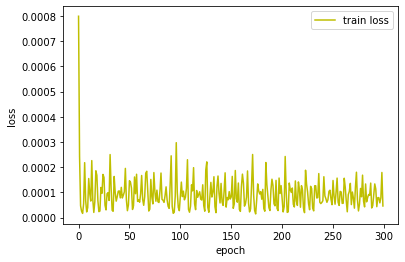

result :  0.001916524680221782


In [7]:
# 5. 모델 학습 과정 표시하기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper right')
plt.show()
print('result : ', results)

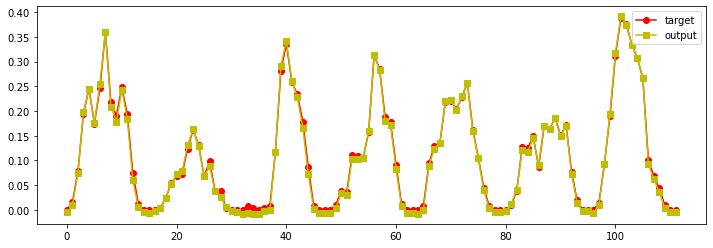

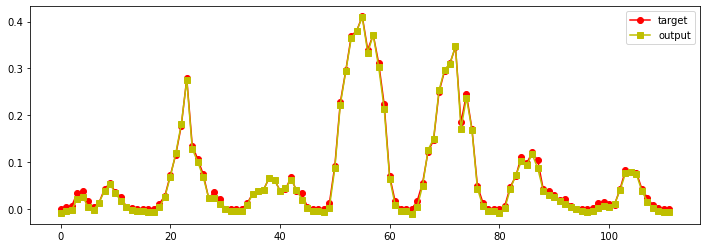

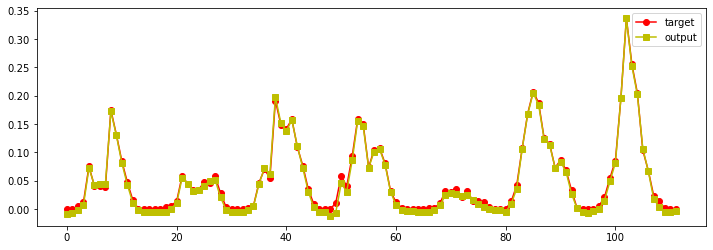

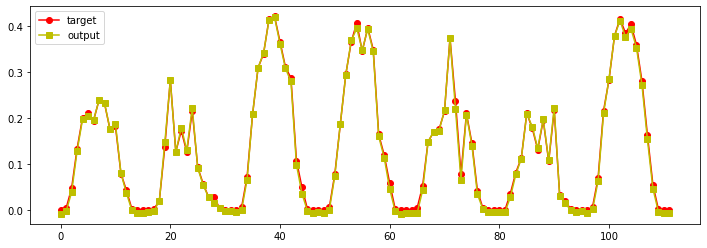

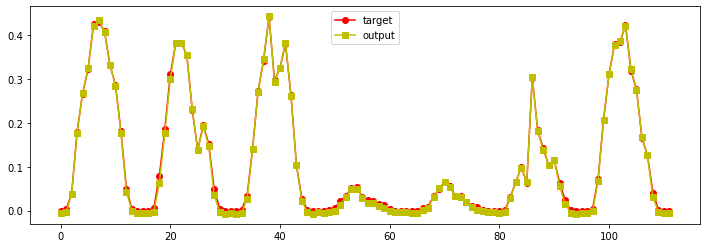

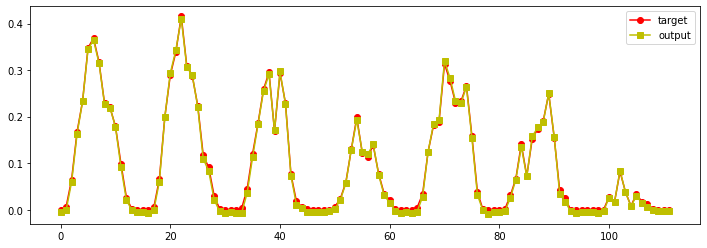

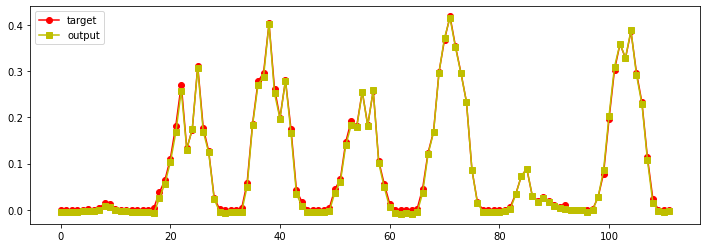

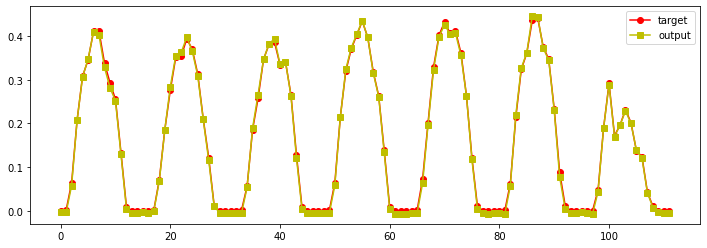

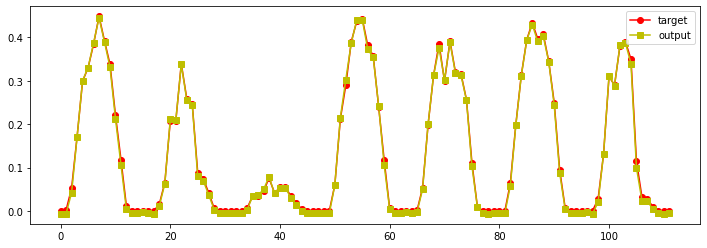

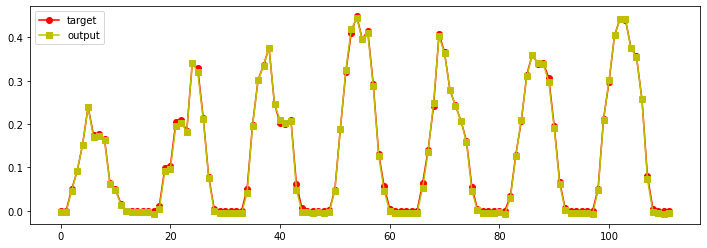

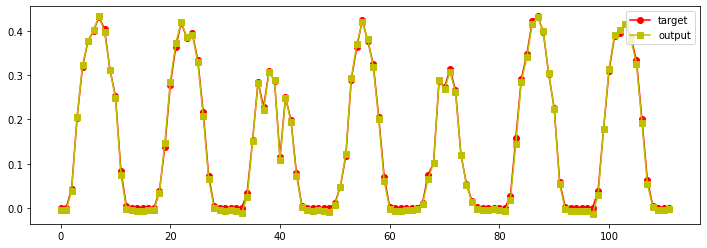

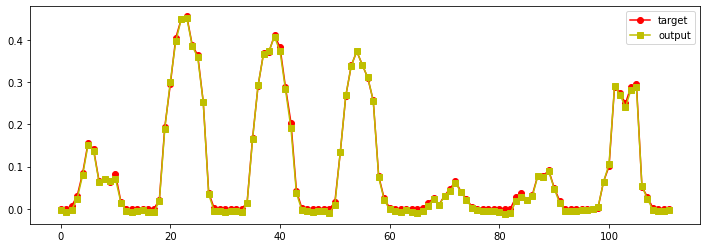

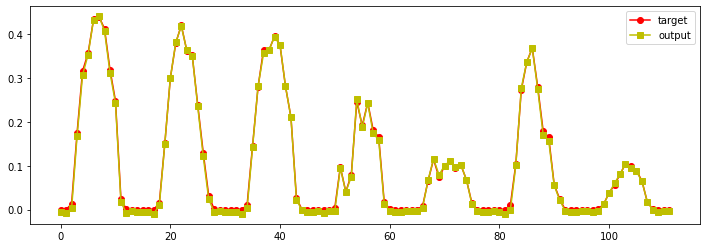

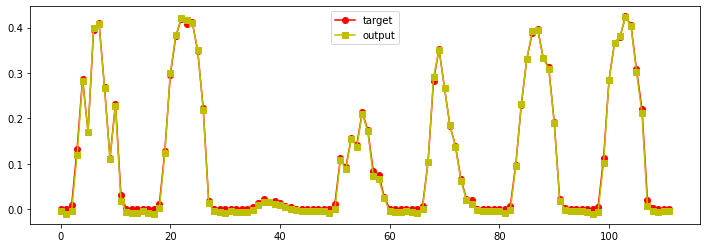

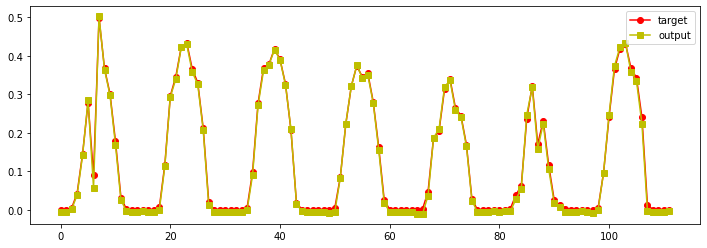

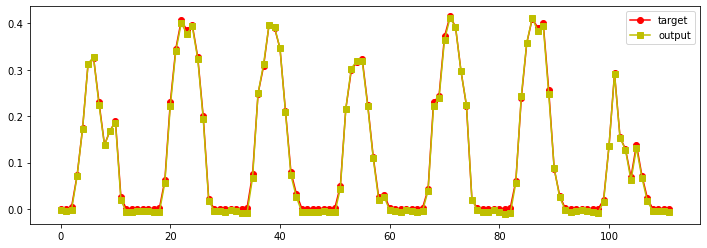

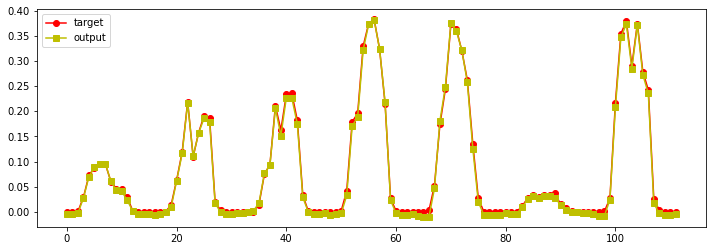

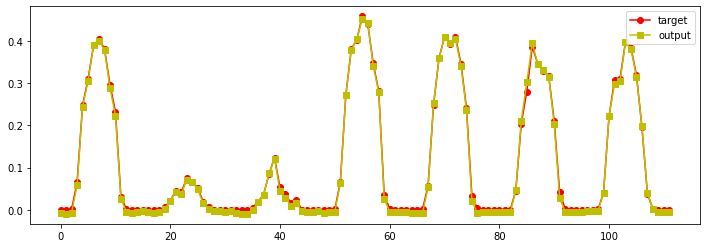

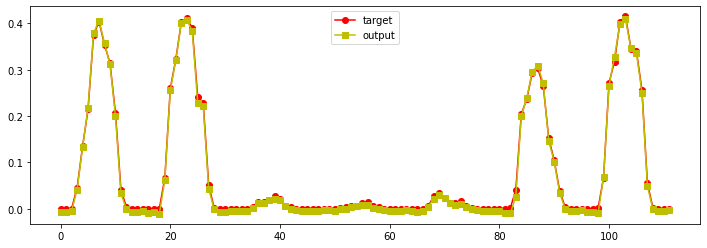

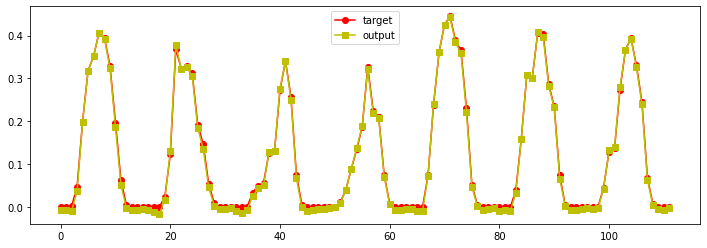

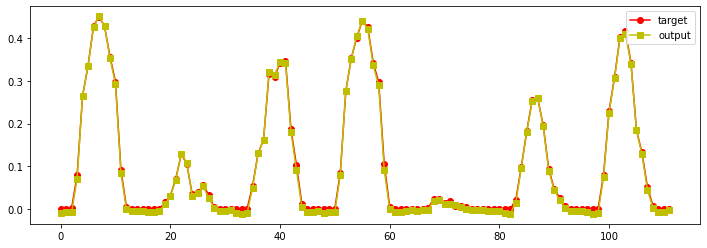

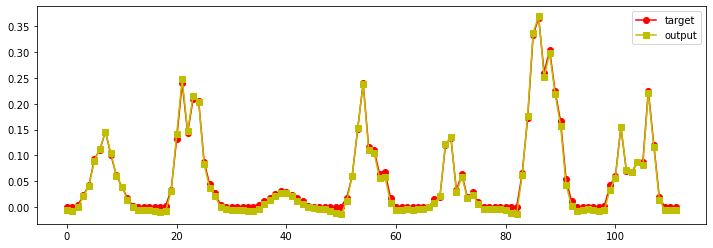

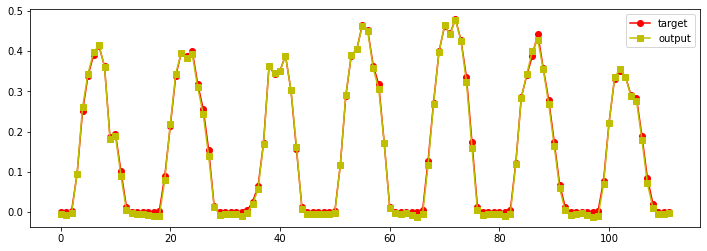

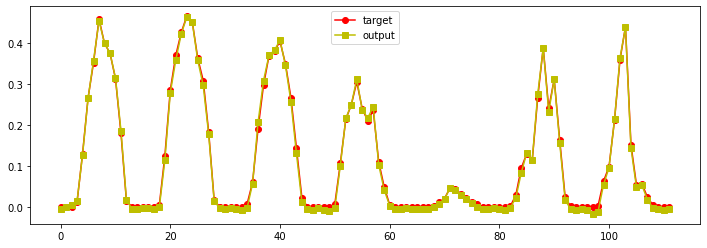

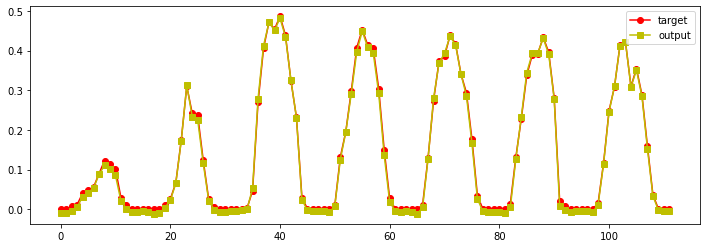

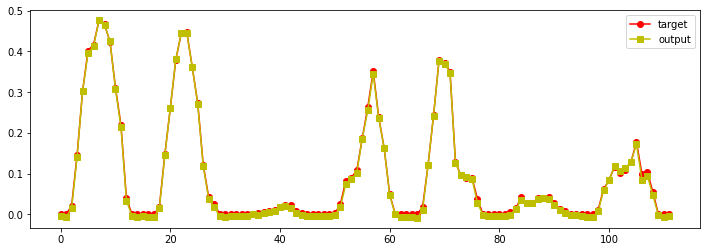

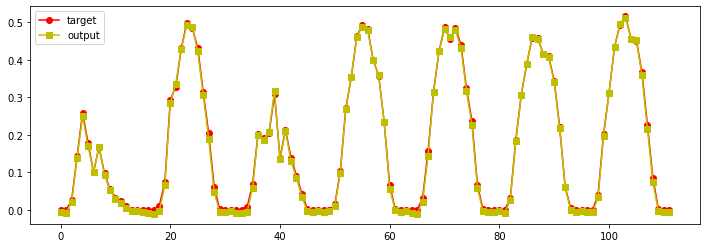

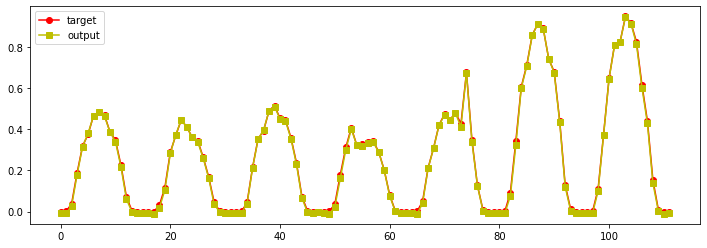

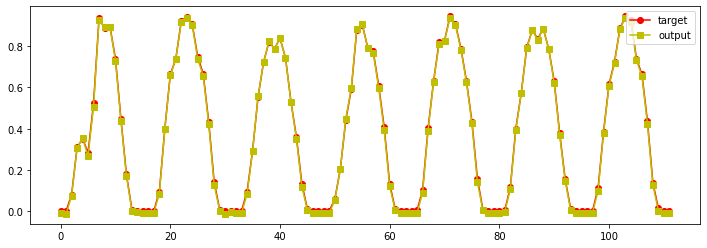

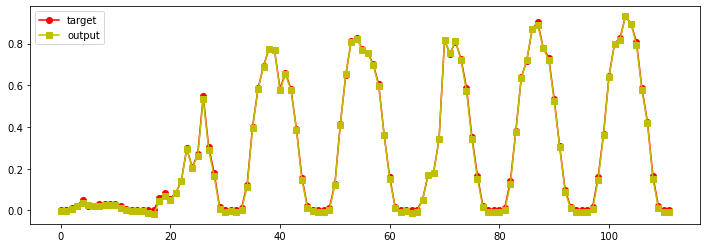

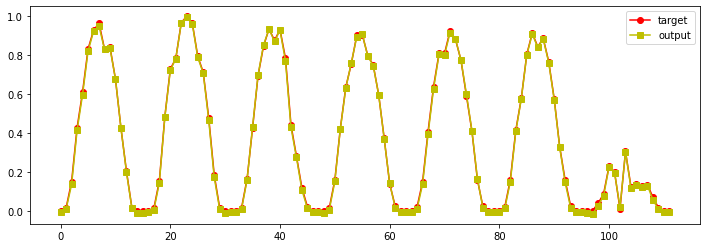

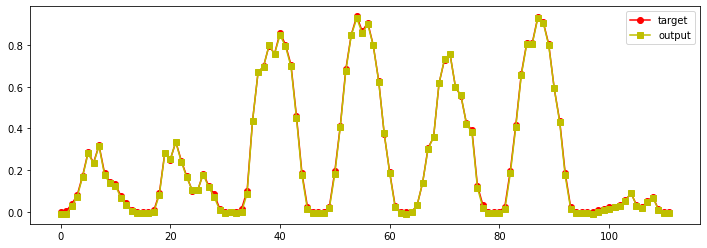

In [8]:
plotY = trainY.reshape(-1,1)
plotY_pred = model.predict(trainX).reshape(-1,1)

end = 48
step = hoursteps*7
for i in range(0, plotY.shape[0]-step, step):
#for i in range(0, 240-step, step):
    plt.rcParams["figure.figsize"] = (12,4)
    plt.plot(plotY[i:i+step], 'ro-', label="target")
    plt.plot(plotY_pred[i:i+step], 'ys-', label="output")
    plt.legend()
    plt.show()

#print(plotY_pred)

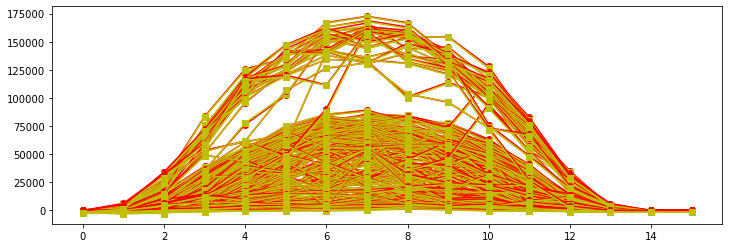

In [9]:
y = sc_pow.inverse_transform(trainY[:,:,0])
plotY = y.reshape(-1,1)

pred = model.predict(trainX)[:,:,0]
#pred[pred<0] = 0

x = sc_pow.inverse_transform(pred)
plot_pred = x.reshape(-1,1)

acc_list = []
target_list=[]

for i in range(0, plotY.shape[0]-hoursteps, hoursteps):
    plt.rcParams["figure.figsize"] = (12,4)
    plt.plot(plotY[i:i+hoursteps], 'ro-', label="target")
    plt.plot(plot_pred[i:i+hoursteps], 'ys-', label="output")
    #plt.legend()
    #plt.show()
    
    pred = np.sum(plot_pred[i:i+hoursteps])
    target      = round(np.sum(plotY[i:i+hoursteps]), 2)
    
    error       = round(np.abs(target-pred), 2)
    error_rate  = round(error/target, 2)
    acc_rate    = np.max([round((1.0-error_rate)*100, 2),0])
    
    target_list.append(target)
    acc_list.append(acc_rate)
    #print("   pred: ",pred," | target: ",target," | error: ",error," | err rate: ",error_rate," | acc: ",acc_rate,sep="")

mean(acc rate): 93.12334801762114


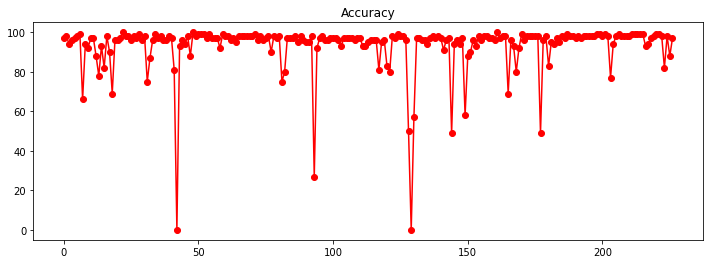

[97.0, 98.0, 94.0, 96.0, 97.0, 98.0, 99.0, 66.0, 94.0, 92.0, 97.0, 97.0, 88.0, 78.0, 93.0, 82.0, 98.0, 90.0, 69.0, 96.0, 96.0, 97.0, 100.0, 98.0, 98.0, 96.0, 98.0, 97.0, 99.0, 96.0, 98.0, 75.0, 87.0, 96.0, 99.0, 97.0, 98.0, 96.0, 96.0, 98.0, 97.0, 81.0, 0.0, 93.0, 96.0, 94.0, 98.0, 88.0, 100.0, 98.0, 99.0, 99.0, 99.0, 97.0, 99.0, 97.0, 97.0, 97.0, 92.0, 99.0, 98.0, 98.0, 96.0, 97.0, 95.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 99.0, 96.0, 98.0, 96.0, 97.0, 98.0, 90.0, 98.0, 97.0, 98.0, 75.0, 80.0, 97.0, 97.0, 97.0, 98.0, 95.0, 98.0, 96.0, 95.0, 95.0, 98.0, 27.0, 92.0, 97.0, 98.0, 96.0, 96.0, 97.0, 97.0, 97.0, 96.0, 93.0, 97.0, 97.0, 97.0, 97.0, 96.0, 97.0, 97.0, 93.0, 93.0, 95.0, 96.0, 96.0, 96.0, 81.0, 95.0, 96.0, 83.0, 80.0, 98.0, 97.0, 99.0, 98.0, 98.0, 96.0, 50.0, 0.0, 57.0, 97.0, 97.0, 96.0, 96.0, 94.0, 97.0, 98.0, 97.0, 98.0, 97.0, 91.0, 96.0, 97.0, 49.0, 94.0, 96.0, 94.0, 97.0, 58.0, 88.0, 90.0, 96.0, 93.0, 98.0, 96.0, 98.0, 98.0, 97.0, 97.0, 96.0, 100.0, 97.0, 98.0, 98.0, 69.0, 96

In [10]:
print("mean(acc rate): ",np.mean(acc_list),sep='')
    
#plotAcc = np.array(acc_list).reshape(-1,1)
plt.plot(acc_list, 'ro-')
plt.title("Accuracy")
plt.show()
print(acc_list)


# model들 acc 평균 출력

In [14]:

from keras.models import load_model

#get test data
X_test = np.load("npset/"+season_mod+"_testX.npy")
y_test = np.load("npset/"+season_mod+"_testY.npy")

#get pow scale form
#powdata, scaler = libs_yeon.get_pow()

print("X_test : ", X_test.shape)
print("y_test : ", y_test.shape)

n_dataset   = y_test.shape[0]
acc_list    = []
acc_model   = []
model       = []

for i in range(n_model):
    model.append(load_model('model/model_'+season_mod+'_'+str(i)+'.h5'))
    acc_model.append(0)
    
print("[ dataset ]")
for i in range(n_dataset):
    #if(i in [0,5,13,14,24,25]): continue;
    y = sc_pow.inverse_transform(y_test[i:i+1,:,0])

    for m in range(n_model):
        #print("(model",m+1,")\t",end="")

        pred = model[m].predict([X_test[i:i+1]])
        pred[pred<0] = 0
        pred = pred[:,:,0]
        pred = sc_pow.inverse_transform(pred)
        pred = np.sum(pred)

        target      = round(np.sum(y), 2)
        error       = round(np.abs(target-pred), 2)
        error_rate  = np.min([round(error/target, 2),1])
        acc_rate    = round((1.0-error_rate)*100, 2)
        acc_list.append(acc_rate)
        acc_model[m] += acc_rate
                 
        #print("   pred: ",pred," | target: ",target," | error: ",error," | err rate: ",error_rate," | acc: ",acc_rate,sep="")
        
    #print("acc rate: ",np.mean(acc_list[-n_model:]),sep='')
    print(np.mean(acc_list[-n_model:]), " / ",sep='', end='')
        
print("\n----------------------------------------------")
print("mean(acc rate): ",np.mean(acc_list),sep='')
print("----------------------------------------------")
print("[ model ]")
for i in range(n_model):
    acc_model[i] = round(acc_model[i]/(n_dataset),2)
    print(acc_model[i])

X_test :  (34, 48, 6)
y_test :  (34, 16, 1)


c:\users\vislab_phy\anaconda3\envs\py37\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


[ dataset ]
31.1 / 79.9 / 80.7 / 76.0 / 81.2 / 48.9 / 87.2 / 73.3 / 80.4 / 83.5 / 86.4 / 85.9 / 90.7 / 12.8 / 11.3 / 92.3 / 61.4 / 86.0 / 88.4 / 84.2 / 65.2 / 87.8 / 81.5 / 90.7 / 0.0 / 50.6 / 94.0 / 92.0 / 86.9 / 93.8 / 73.0 / 61.0 / 82.4 / 75.8 / 
----------------------------------------------
mean(acc rate): 72.24411764705883
----------------------------------------------
[ model ]
77.59
73.06
73.06
71.29
71.56
70.74
70.06
70.18
75.0
69.91


In [16]:

from keras.models import load_model

#get test data
X_test = np.load("npset/"+season_mod+"_testX.npy")
y_test = np.load("npset/"+season_mod+"_testY.npy")

#get pow scale form
#powdata, scaler = libs_yeon.get_pow()

print("X_test : ", X_test.shape)
print("y_test : ", y_test.shape)

n_dataset   = y_test.shape[0]
acc_list    = []
acc_model   = []
model       = []

for i in range(n_model):
    model.append(load_model('model/model_'+season_mod+'_'+str(i)+'.h5'))
    acc_model.append(0)
    
print("[ dataset ]")
for i in range(n_dataset):
    if(i in [0,5,13,14,16,24,25,31,30]): continue;
    y = sc_pow.inverse_transform(y_test[i:i+1,:,0])

    for m in range(n_model):
        #print("(model",m+1,")\t",end="")

        pred = model[m].predict([X_test[i:i+1]])
        pred[pred<0] = 0
        pred = pred[:,:,0]
        pred = sc_pow.inverse_transform(pred)
        pred = np.sum(pred)

        target      = round(np.sum(y), 2)
        error       = round(np.abs(target-pred), 2)
        error_rate  = np.min([round(error/target, 2),1])
        acc_rate    = round((1.0-error_rate)*100, 2)
        acc_list.append(acc_rate)
        acc_model[m] += acc_rate
                 
        #print("   pred: ",pred," | target: ",target," | error: ",error," | err rate: ",error_rate," | acc: ",acc_rate,sep="")
        
    #print("acc rate: ",np.mean(acc_list[-n_model:]),sep='')
    print(np.mean(acc_list[-n_model:]), " / ",sep='', end='')
        
print("\n----------------------------------------------")
print("mean(acc rate): ",np.mean(acc_list),sep='')
print("----------------------------------------------")
print("[ model ]")
for i in range(n_model):
    acc_model[i] = round(acc_model[i]/(n_dataset-9),2)
    print(acc_model[i])

X_test :  (34, 48, 6)
y_test :  (34, 16, 1)


c:\users\vislab_phy\anaconda3\envs\py37\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


[ dataset ]
79.9 / 80.7 / 76.0 / 81.2 / 87.2 / 73.3 / 80.4 / 83.5 / 86.4 / 85.9 / 90.7 / 92.3 / 86.0 / 88.4 / 84.2 / 65.2 / 87.8 / 81.5 / 90.7 / 94.0 / 92.0 / 86.9 / 93.8 / 82.4 / 75.8 / 
----------------------------------------------
mean(acc rate): 84.248
----------------------------------------------
[ model ]
86.16
81.28
84.68
84.88
84.72
84.2
84.32
83.28
87.2
81.76
